# Projeto Inteligência Artifical (Afonso Fernandes - 2221437, Luís Oliveira - 2221441)

- Conjunto de validação train4

## Modelos:

### S

- Modelo de raíz 

- Otimizador: 

- Com e sem Data Augmentation

## Dados Base:

In [1]:
from keras.utils import image_dataset_from_directory
import tensorflow as tf
train_dir_1 = 'trainning/train1'
train_dir_2 = 'trainning/train2'
train_dir_3 = 'trainning/train3'
validation_dir = 'train4' # Validation
train_dir_5 = 'trainning/train5'
test_dir = 'test'

trainning = [train_dir_1, train_dir_2,train_dir_3,train_dir_5]

train_dir = train_dir_2
IMG_SIZE = 32 # 32x32

# image_dataset_from_directory with labels="inferred" for 
# getting the images in the subdirectories and translating the subdirectory as a class 
# of type categorical
#train_dataset = image_dataset_from_directory(train_dir,image_size=(IMG_SIZE, IMG_SIZE),batch_size=32, labels="inferred", label_mode="categorical")
test_dataset = image_dataset_from_directory(test_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")
validation_dataset = image_dataset_from_directory(validation_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")

train_dataset = tf.data.Dataset

for i in trainning:
    if i == trainning[0]:
        train_dataset = image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical")
        continue
    train_dataset = train_dataset.concatenate( image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical"))




Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


### Gráfico da validation accuracy vs test accuracy

In [2]:
import matplotlib.pyplot as plt

def graph(history):
    # Use the correct key names from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


data batch shape: (32, 32, 32, 3)
labels batch shape: (32, 10)


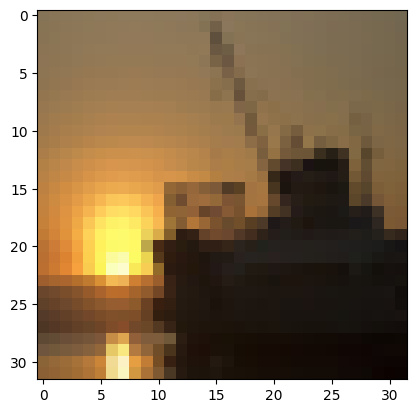

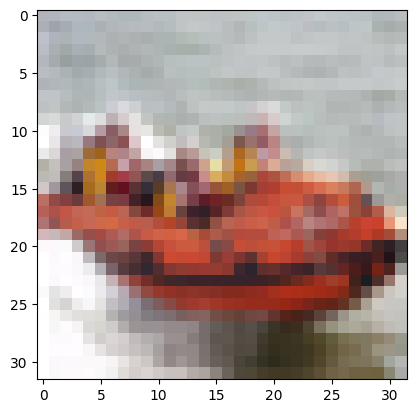

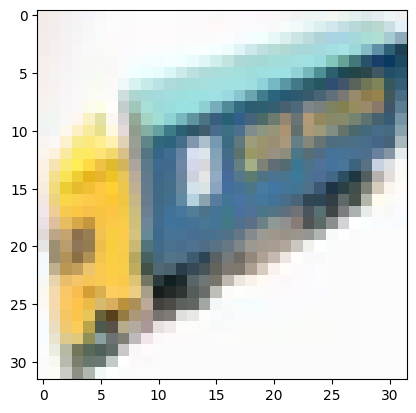

In [3]:
import matplotlib.pyplot as plt
for data_batch, labels_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break
for data_batch, _ in train_dataset.take(1):
  for i in range(3):
    plt.imshow(data_batch[i].numpy().astype("uint8"))
    plt.show()

## Modelo S sem Data augmentation:

In [ ]:
import os
import tensorflow as tf
# Para revêr ou treinar mais
model_path = "models_S/S_without_DA.h5"
model =  tf.keras.models.load_model(model_path)


In [ ]:
model.summary()

### Optimização da procura de hyperparâmetros através do optuna 

In [ ]:
import optuna
import keras
from keras import layers



def create_model(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 3)
    #making the model
    reg = keras.regularizers.l2(0.005)
    dropConv = 0.2
    dropFinal = 0.5
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    for i in range(n_conv_layers):
        n_filters = trial.suggest_int('n_filters1_{}'.format(i), 32, 128, step=32)
        n_filters2 = trial.suggest_int('n_filters2_{}'.format(i), 32, 128, step=32)
        n_ksize = trial.suggest_int('n_ksize1_{}'.format(i), 2, 3)
        n_ksize1 = trial.suggest_int('n_ksize2_{}'.format(i), 2, 3)
        x = layers.Conv2D(filters=n_filters, kernel_size=n_ksize,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.Conv2D(filters=n_filters2, kernel_size=n_ksize1,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Dropout(dropConv)(x)

        
    #The flatten and classification process    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=reg)(x) #trial.suggest_int('dense_units', 512, 1024, step=512)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropFinal)(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2, log=True),
    decay_steps=10000,
    decay_rate=0.6)

    # Suggest optimizer
    optimizer_options = ['Adam', 'RMSprop']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        filepath=f'models_S/model_best_{trial.number}.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='min',
        restore_best_weights=True,
    )]
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)

    
    history = model.fit(train_dataset,
                        batch_size=batch_size,
                        epochs=30,  
                        validation_data=validation_dataset,
                        callbacks=callbacks,
                        verbose=0)  # não verboso
    graph(history)
    val_loss = history.history['val_loss'][-1]
    return val_loss

### Utilização do Optuna:
- Criação do Modelo com os campos dos hyperparâmetros com sugestões de valores para serem testados

- Definição do objetivo de maximizar a accuracy e callback para guardar sempre o melhor modelo definido pela accuracy 

[I 2024-06-19 17:12:17,850] A new study created in memory with name: no-name-c2f53027-0f57-40d9-a0d9-0a731b6b2db8

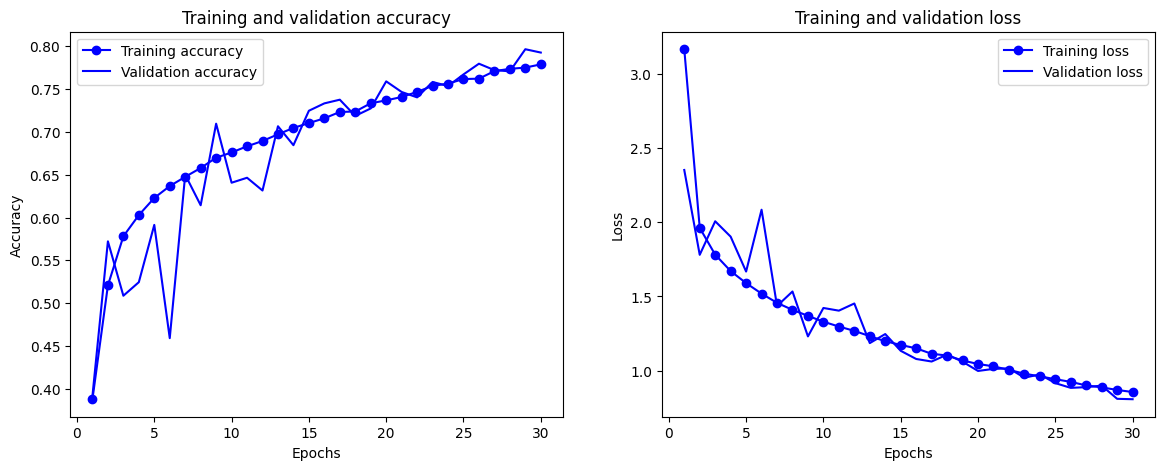

[I 2024-06-19 18:05:48,769] 

Trial 1 finished with value: 0.8066616654396057 and parameters: 

{'n_conv_layers': 3, 

'n_filters1_0': 128, 

'n_filters2_0': 96, 

'n_ksize1_0': 3, 

'n_ksize2_0': 2, 

'n_filters1_1': 32, 

'n_filters2_1': 32, 

'n_ksize1_1': 3, 

'n_ksize2_1': 2, 

'n_filters1_2': 96, 

'n_filters2_2': 32,

 'n_ksize1_2': 2, 
 
 'n_ksize2_2': 2, 
 
 'learning_rate_IN': 0.0020018655778243685, 
 
 'optimizer': 'RMSprop', 
 
 'batch_size': 128}. 
 
 Best is trial 1 with value: 0.8066616654396057.


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=6)  # Ajustar número de trials para um estudo mais completo

print(f"Best trial: {study.best_trial.params}")


- Com o modelo já carregado do ficheiro, continuar o treino

In [ ]:
import os
import tensorflow as tf

model_path = "models_S/S_without_DA_1.h5"
model =  tf.keras.models.load_model(model_path)


In [28]:

callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='models_S/S_without_DA.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
)]
    
    
history = model.fit(
    train_dataset,
    epochs=100,  
    batch_size=128,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)  # # sim/não verboso

Epoch 1/100
1251/1252 [============================>.] - ETA: 0s - loss: 0.8367 - accuracy: 0.7999
Epoch 1: val_loss improved from inf to 0.81660, saving model to models_S\S_without_DA.h5
1252/1252 [==============================] - 103s 80ms/step - loss: 0.8367 - accuracy: 0.7999 - val_loss: 0.8166 - val_accuracy: 0.8015
Epoch 2/100
1250/1252 [============================>.] - ETA: 0s - loss: 0.8224 - accuracy: 0.8013
Epoch 2: val_loss improved from 0.81660 to 0.81083, saving model to models_S\S_without_DA.h5
1252/1252 [==============================] - 37s 29ms/step - loss: 0.8224 - accuracy: 0.8013 - val_loss: 0.8108 - val_accuracy: 0.7999
Epoch 3/100
1252/1252 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.8068
Epoch 3: val_loss did not improve from 0.81083
1252/1252 [==============================] - 31s 24ms/step - loss: 0.8118 - accuracy: 0.8068 - val_loss: 0.8255 - val_accuracy: 0.7993
Epoch 4/100
1252/1252 [==============================] - ETA: 0s - l

- Avaliar Modelo:

In [29]:
val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc,'\nval_loss:', val_loss)

313/313 [==============================] - 4s 13ms/step - loss: 0.7557 - accuracy: 0.8209
val_acc: 0.820900022983551 
val_loss: 0.7556588649749756


- Guardar o modelo depois de ter sido treinado:

In [ ]:
# Guardar por alguma razão extra
keras.models.save_model(model,"models_S\S_without_DA.h5")

## Modelo S com Data augmentation:

- Parecido com o feito anteriormente mas com Data augmentation:

### Optimização da procura de hyperparâmetros através do optuna com Data Augmentation

In [ ]:
import optuna
import keras
from keras import layers


def create_model(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 3)
    # Definição da augmentação da informação
    reg = keras.regularizers.l2(0.005)
    dropConv = 0.2
    dropFinal = 0.5
    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),])
    #
    # Criação do dito Modelo
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Data augmentation
    x = data_augmentation(inputs)
    #
    x = layers.Rescaling(1./255)(inputs)
    for i in range(n_conv_layers):
        n_filters = trial.suggest_int('n_filters1_{}'.format(i), 32, 128, step=32)
        #n_filters2 = trial.suggest_int('n_filters2_{}'.format(i), 32, 128, step=32)
        n_filters2 = n_filters 
        n_ksize = trial.suggest_int('n_ksize1_{}'.format(i), 2, 3)
        #n_ksize1 = trial.suggest_int('n_ksize2_{}'.format(i), 2, 3)
        n_ksize1 = n_ksize
        x = layers.Conv2D(filters=n_filters, kernel_size=n_ksize,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.Conv2D(filters=n_filters2, kernel_size=n_ksize1,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Dropout(dropConv)(x)

        
    #The flatten and classification process    
    x = layers.Flatten()(x)
    x = layers.Dense(trial.suggest_int('dense_units', 256, 512, step=256), activation="relu", kernel_regularizer=reg)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropFinal)(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2, log=True),
    decay_steps=10000,
    decay_rate=0.6)

    # Suggest optimizer
    optimizer_options = ['Adam', 'RMSprop']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        filepath=f'models_S/model_best_DA_{trial.number}.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=1,
        mode='min',
        restore_best_weights=True,
    )]
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)

    
    history = model.fit(train_dataset,
                        batch_size=batch_size,
                        epochs=50,  
                        validation_data=validation_dataset,
                        callbacks=callbacks,
                        verbose=0)  # não verboso
    graph(history)
    val_loss = history.history['val_loss'][-1]
    return val_loss

### Utilização do Optuna:
- Criação do Modelo com os campos dos hyperparâmetros com sugestões de valores para serem testados

- Definição do objetivo de maximizar a accuracy e callback para guardar sempre o melhor modelo definido pela accuracy 

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)   # Ajustar número de trials para um estudo mais completo

print(f"Best trial: {study.best_trial.params}")


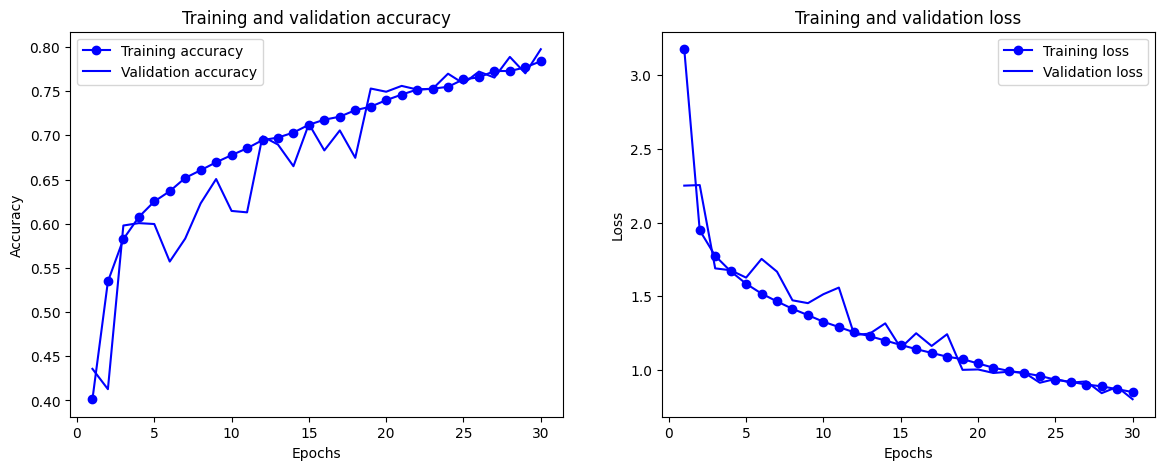

Utilização dos parâmetros encontrados no Modelo S sem Data Augmentation

In [33]:
import keras
# Load do novo melhor modelo
best_model = keras.models.load_model("models_S\model_best_DA_0.h5")

In [34]:
model.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_48 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_150 (Conv2D)         (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_216 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                               
                                                                 
 conv2d_151 (Conv2D)         (None, 32, 32, 96)        49248     
                                                                 
 batch_normalization_217 (Ba  (None, 32, 32, 96)       384       
 tchNormalization)                                        

In [35]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='models_S/S_with_DA.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    ), keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=0,
        mode='min',
        restore_best_weights=True,
    )]
    
    
history = best_model.fit(
    train_dataset,
    epochs=100, batch_size=128, 
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


1252/1252 [==============================] - 51s 39ms/step - loss: 0.8115 - accuracy: 0.7906 - val_loss: 0.7876 - val_accuracy: 0.7982
Epoch 2/100
1252/1252 [==============================] - 48s 38ms/step - loss: 0.7882 - accuracy: 0.7959 - val_loss: 0.7700 - val_accuracy: 0.8023
Epoch 3/100
1252/1252 [==============================] - 49s 39ms/step - loss: 0.7799 - accuracy: 0.7983 - val_loss: 0.7618 - val_accuracy: 0.8073
Epoch 4/100
1252/1252 [==============================] - 49s 39ms/step - loss: 0.7652 - accuracy: 0.8001 - val_loss: 0.8270 - val_accuracy: 0.7853
Epoch 5/100
1252/1252 [==============================] - 49s 39ms/step - loss: 0.7522 - accuracy: 0.8021 - val_loss: 0.7307 - val_accuracy: 0.8153
Epoch 6/100
1252/1252 [==============================] - 51s 40ms/step - loss: 0.7387 - accuracy: 0.8076 - val_loss: 0.7288 - val_accuracy: 0.8113
Epoch 7/100
1252/1252 [==============================] - 49s 39ms/step - loss: 0.7318 - accuracy: 0.8084 - val_loss: 0.7160 - val_

- Avaliar Modelo:

In [37]:
val_loss, val_acc = best_model.evaluate(validation_dataset)
print('val_acc:', val_acc,'\nval_loss:', val_loss)

313/313 [==============================] - 5s 15ms/step - loss: 0.6307 - accuracy: 0.8313
val_acc: 0.8313000202178955 
val_loss: 0.6306564211845398


- Guardar o modelo depois de ter sido treinado:

In [38]:
keras.models.save_model(best_model,"models_S\S_with_DA.h5")